### Data Loading

In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape

(1000, 13551)

In [93]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Data preprocessing

In [153]:
def preprocess_X(X):
    X = X.toarray()
    return np.log1p(X * 1e4/ X.sum(axis=1)[:, np.newaxis])

X_train_norm = preprocess_X(X_train)

# # sanity check
# np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

In [110]:
X_train_norm.shape

(1000, 13551)

Analyse the number of components that we should use for PCA

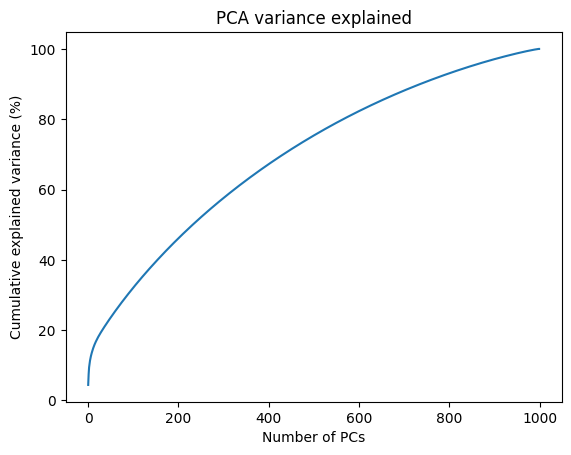

In [117]:
n_pcs = 1000
pca = PCA(n_components=n_pcs)
X_norm_pca = pca.fit_transform(X_train_norm)

plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA variance explained")
plt.show()

In [143]:
print("Cummulative Explained variance ratio (Last 10 PCs):", np.cumsum(pca.explained_variance_ratio_)[690:700])

Cummulative Explained variance ratio (Last 10 PCs): [0.8762322  0.8767771  0.8773215  0.8778655  0.87840873 0.8789507
 0.87949216 0.8800318  0.88057125 0.8811096 ]


### Model Building

In [ ]:
# Logistic Regression Pipeline
logistic_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 700 components", PCA(n_components=700)),
        (
            "Logistic Regression",
                LogisticRegression(
                    solver='lbfgs',
                    penalty='l2',
                    C=1,
                    max_iter=1000,
                    # class_weight='balanced',
                    random_state=42,
                )
        ),
    ]
)

logistic_pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 700 components', PCA(n_components=700)),
                ('Logistic Regression',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [167]:
# Random Forest Regression Pipeline
rf_pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 700 components", PCA(n_components=700)),
        (
            "Random Forest",
            RandomForestClassifier(
                n_estimators=300,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42,
                # n_jobs=-1  # Use all cores
            )
        ),
    ]
)

In [169]:
# fit on train
pipe = logistic_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.807


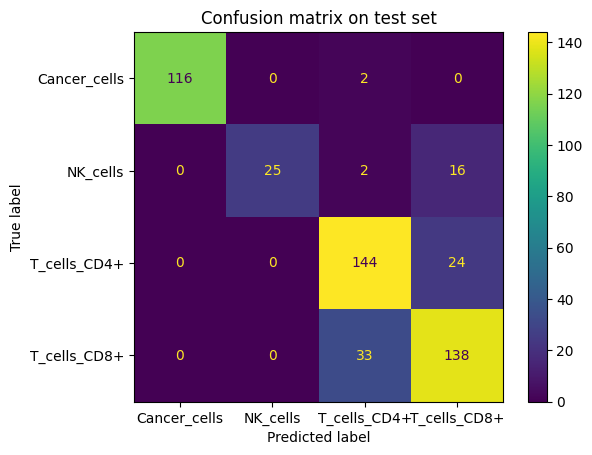

In [170]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");